In [1]:
!pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2


In [ ]:
!pip install tensorflow==2.8.0 tensorflow-gpu==2.8.0 opencv-python matplotlib


In [3]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cv2

In [4]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
path= '/content/drive/MyDrive/VITON/lite-model_movenet_singlepose_lightning_3.tflite'

In [6]:
#load model
interpreter = tf.lite.Interpreter(model_path=path)
interpreter.allocate_tensors()

In [7]:
interpreter.get_output_details()

[{'name': 'StatefulPartitionedCall:0',
  'index': 312,
  'shape': array([ 1,  1, 17,  3], dtype=int32),
  'shape_signature': array([ 1,  1, 17,  3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [8]:
# capture from the webcam, and unpack the read cam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    # Reshape image
    img = frame.copy()
    img = tf.image.resize_with_pad(np.expand_dims(img, axis=0), 192,192)
    input_image = tf.cast(img, dtype=tf.float32)

    # Setup input and output
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Make predictions
    interpreter.set_tensor(input_details[0]['index'], np.array(input_image))
    interpreter.invoke()
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])

    # Rendering
    draw_connections(frame, keypoints_with_scores, EDGES, 0.4)
    draw_keypoints(frame, keypoints_with_scores, 0.4)

    cv2.imshow('MoveNet Lightning', frame)

    # to close and release the webcam
    if cv2.waitKey(10) & 0xFF==ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [9]:
def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))

    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 4, (0,255,0), -1)

In [10]:
EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

In [13]:
def draw_connections(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))

    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]

        if (c1 > confidence_threshold) & (c2 > confidence_threshold):
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)

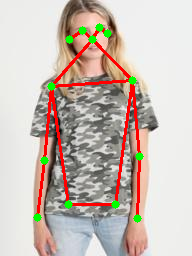

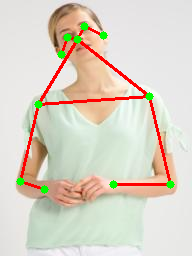

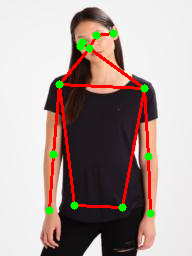

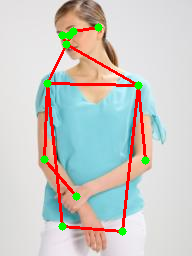

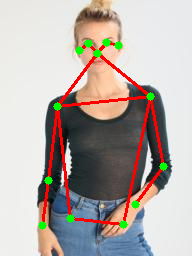

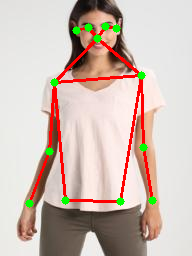

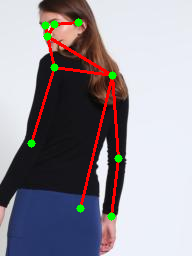

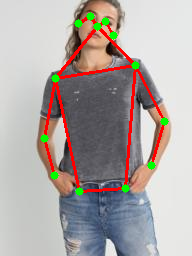

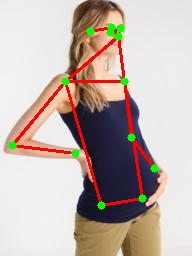

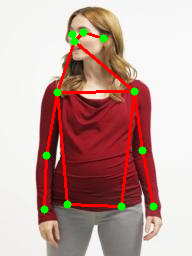

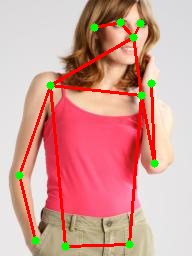

In [15]:
import cv2
import os
import json
from google.colab.patches import cv2_imshow

# Path to the folder containing the images
image_folder = "/content/drive/MyDrive/VITON/image/"

# Path to the folder where the keypoints will be saved
keypoints_folder = "/content/drive/MyDrive/VITON/keypoints/"
os.makedirs(keypoints_folder, exist_ok=True)

# List all the image files in the folder
image_files = os.listdir(image_folder)

# Load and process each image
for image_file in image_files:
    # Load the pre-recorded image
    image_path = os.path.join(image_folder, image_file)
    frame = cv2.imread(image_path)

    # Reshape image
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (192, 192))
    input_image = tf.expand_dims(img, axis=0)
    input_image = tf.cast(input_image, dtype=tf.float32)

    # Setup input and output
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Set input tensor
    interpreter.set_tensor(input_details[0]['index'], input_image)

    # Run inference
    interpreter.invoke()

    # Get keypoints predictions
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])

    # Save keypoints in .json file
    keypoints_dict = {
        'keypoints': keypoints_with_scores.tolist(),
        'image_path': image_path,
        'image_shape': frame.shape
    }
    keypoints_file = os.path.join(keypoints_folder, os.path.splitext(image_file)[0] + '.json')
    with open(keypoints_file, 'w') as f:
        json.dump(keypoints_dict, f)

    # Rendering
    draw_connections(frame, keypoints_with_scores, EDGES, 0.4)
    draw_keypoints(frame, keypoints_with_scores, 0.4)

    # Display the image
    cv2_imshow(frame)
